# Home Credit data
# Notebook 2: Statistical Inference

**Table of contents**<a id='toc0_'></a>    
- 1. [Introduction](#toc1_)    
  - 1.1. [Libraries](#toc1_1_)    
  - 1.2. [Load data](#toc1_2_)    
- 2. [Statistical inference and evaluation](#toc2_)    
  - 2.1. [Target population](#toc2_1_)    
  - 2.2. [Hypotheses testing](#toc2_2_)    
    - 2.2.1. [Hypothesis 1: Impact of the social circle](#toc2_2_1_)    
      - 2.2.1.1. [Hypothesis formulations](#toc2_2_1_1_)    
      - 2.2.1.2. [Hypothesis testing](#toc2_2_1_2_)    
    - 2.2.2. [Hypothesis 2: Male vs. Female](#toc2_2_2_)    
      - 2.2.2.1. [Hypotheses formulations](#toc2_2_2_1_)    
      - 2.2.2.2. [Hypothesis testing](#toc2_2_2_2_)    
    - 2.2.3. [Hypothesis 3: Education level](#toc2_2_3_)    
      - 2.2.3.1. [Hypotheses formulations](#toc2_2_3_1_)    
      - 2.2.3.2. [EDUCATION_LEVEL](#toc2_2_3_2_)    
      - 2.2.3.3. [Test assumptions: Part 1](#toc2_2_3_3_)    
      - 2.2.3.4. [Hypothesis testing](#toc2_2_3_4_)    
      - 2.2.3.5. [Test assumptions: Part 2](#toc2_2_3_5_)    
  - 2.3. [Results](#toc2_3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Introduction](#toc0_)

### 1.1. <a id='toc1_1_'></a>[Libraries](#toc0_)

In [ ]:
import os
import sys

sys.path.append(os.path.abspath(".."))

from src.utils import plot_feature_distribution

import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
from src.utils import (
    plot_proportion_with_ci,
    plot_difference_in_proportion,
    plot_coef_with_ci,
    box_tidwell_test,
    plot_partial_residuals,
)

### 1.2. <a id='toc1_2_'></a>[Load data](#toc0_)

In [ ]:
application_train = pd.read_csv("../data/raw/application_train.csv")

## 2. <a id='toc2_'></a>[Statistical inference and evaluation](#toc0_)

### 2.1. <a id='toc2_1_'></a>[Target population](#toc0_)

The analyses presented in this report are based on the **Home Credit Default Risk** dataset, originally released as part of a machine learning competition hosted on Kaggle by Home Credit Group. The dataset includes application-level data from **clients applying for various types of consumer loans**, such as cash loans and revolving credit, through Home Credit’s lending services.

The target population represented by this dataset consists of **individuals who applied for a loan product at Home Credit**. These applicants may include both those who were eventually granted a loan and those who were rejected, depending on the inclusion criteria defined by the data provider. The dataset contains a rich set of features capturing demographic characteristics, financial status, employment information, housing details, and behavioral risk indicators, such as past payment history and information about the applicant’s social and family network.

The data are observational and reflect real-world financial behavior and application outcomes. The key target variable, `TARGET`, is binary and indicates whether the applicant **defaulted on the loan within a certain period** after disbursement (`TARGET = 1`) or repaid it successfully (`TARGET = 0`). While the exact time window for measuring default is not specified in detail, it is generally understood to refer to **serious payment difficulties**, such as being more than 90 days overdue.

Although the dataset is extensive and detailed, it should be noted that:

* The data cover only clients who **applied for a loan** with Home Credit, not the general population.
* The dataset does not result from a random sampling procedure; hence, **external validity** and generalizability of inferences beyond the Home Credit applicant population may be limited.
* Personal identifiers have been removed or anonymized, and some variable definitions have been simplified or altered to protect client confidentiality and conform to data privacy standards.

All statistical inferences in this report refer to this defined population of **loan applicants at Home Credit**, based on the characteristics captured in the available dataset. No additional segmentation or subpopulation targeting (e.g., by country, region, or demographic subgroup) has been applied unless otherwise stated.

### 2.2. <a id='toc2_2_'></a>[Hypotheses testing](#toc0_)

The significance level set for all three hypotheses to test is set as $\alpha$ level of 0.05.

#### 2.2.1. <a id='toc2_2_1_'></a>[Hypothesis 1: Impact of the social circle](#toc0_)

##### 2.2.1.1. <a id='toc2_2_1_1_'></a>[Hypothesis formulations](#toc0_)

Based on a first iteration of EDA the following first hypothesis is formulated and should be tested:

1. Someone surrounded by any defaulter in its social circle is at higher risk of defaulting.
 
- Alternative Hypothesis ($H_A(1)$): `DEF_SOCIAL_CIRCLE` has a positive impact on the risk of defaulting $(\beta_{\text{def-social-circle}} > 0)$.
- Null Hypothesis ($H_0(1)$): `DEF_SOCIAL_CIRCLE` has no effect on the risk of defaulting $(\beta_{\text{def-social-circle}} = 0)$.


##### 2.2.1.2. <a id='toc2_2_1_2_'></a>[Hypothesis testing](#toc0_)

**Normality check**

The assumption is that the sample sizes are large enough for the Central Limit Theorem to apply, making the sampling distribution of the proportion differences approximately normal. Therefore, testing the normality of the raw data is not necessary.



**Independent variable**

We combine both features into a single summary feature, since we are interested in exploring their joint effect on the target variable. Taking the sum hghlights how many total risky contacts someone has, which is good for emphasizing density of exposure.

In [4]:
application_train["DEF_SOCIAL_CIRCLE_SUM"] = application_train[
    ["DEF_30_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE"]
].sum(axis=1)
application_train["SOC_DEF_FLAG"] = (
    application_train["DEF_SOCIAL_CIRCLE_SUM"] > 0
).astype(int)

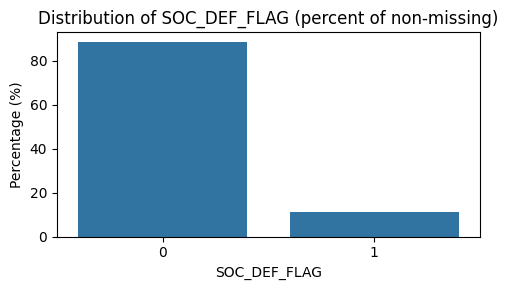

In [5]:
plot_feature_distribution(application_train, "SOC_DEF_FLAG")

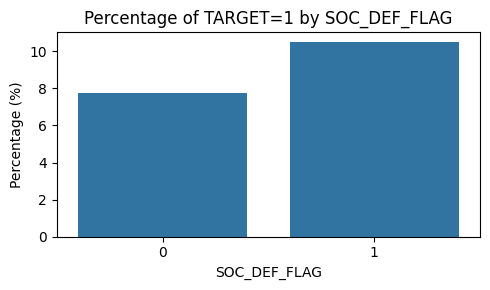

In [6]:
plot_feature_distribution(application_train, "SOC_DEF_FLAG", target_name="TARGET")

**Statistical test**

To test the hypothesis that the presence of defaulters in a client’s social circle influences their own risk of default, a two-proportion Z-test was performed. This statistical test compares the default rates between two groups: clients with at least one defaulter in their social circle (`SOC_DEF_FLAG = 1`) and those without (`SOC_DEF_FLAG = 0`).

The difference in default proportions between these groups was calculated, along with a 95% confidence interval to quantify the uncertainty around this difference. The Z-test evaluates whether the observed difference is statistically significant or could have arisen by chance under the null hypothesis of no difference.

In [7]:
ct = pd.crosstab(application_train["SOC_DEF_FLAG"], application_train["TARGET"])
ct

TARGET,0,1
SOC_DEF_FLAG,,
0,251211,21134
1,31475,3691


Each group in the contingency table contains more than 3,000 cases, which satisfies the sample size requirements for the validity of the Z-test approximation.

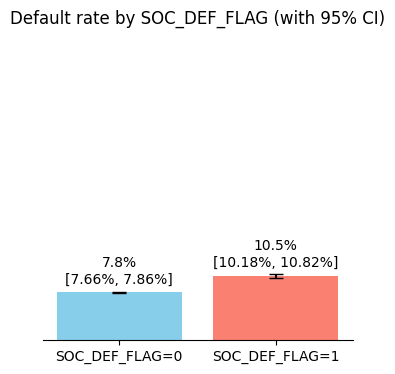

In [8]:
plot_proportion_with_ci(ct, label_prefix="SOC_DEF_FLAG")

In [9]:
success = application_train.groupby("SOC_DEF_FLAG")["TARGET"].sum()
n = application_train.groupby("SOC_DEF_FLAG")["TARGET"].count()

zstat, pval = proportions_ztest(count=success, nobs=n)
print(f"Z = {zstat:.2f}, p = {pval:.4f}")

Z = -17.72, p = 0.0000


The large Z-test statistic and low p-value indicate a statistically significant difference in default rates between individuals with at least one defaulter in their social circle and those without. However, the average difference in proportions is only 2.7%, which is relatively small (see below).

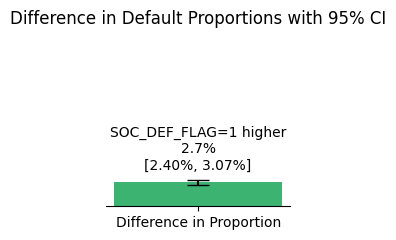

In [10]:
plot_difference_in_proportion(ct, feature_name="SOC_DEF_FLAG")

#### 2.2.2. <a id='toc2_2_2_'></a>[Hypothesis 2: Male vs. Female](#toc0_)

##### 2.2.2.1. <a id='toc2_2_2_1_'></a>[Hypotheses formulations](#toc0_)

2. The risk of defaulting is higher for males.
 
- Alternative Hypothesis ($H_A(2)$): The gender variable `CODE_GENDER` has a positive effect on the risk of defaulting, i.e., the coefficient for male is greater than zero $(\beta_{\text{male}} > 0)$.
- Null Hypothesis ($H_0(2)$): The gender variable `CODE_GENDER` has no effect on the risk of defaulting, i.e., the coefficient for male is zero  $(\beta_{\text{male}} = 0)$.


The significance level set for this hypothesis to test is set a $\alpha$ level of 0.05.

##### 2.2.2.2. <a id='toc2_2_2_2_'></a>[Hypothesis testing](#toc0_)

**Normality check**

The assumption is that the sample sizes are large enough for the Central Limit Theorem to apply, making the sampling distribution of the proportion differences approximately normal. Therefore, testing the normality of the raw data is not necessary.



**Independent variable**

The gender category "XNA" occurs extremely rarely and will therefore be excluded from the dataset to compare only Female vs. Male.

In [11]:
removed = (application_train["CODE_GENDER"] == "XNA").sum()
print(f"Dropped {removed} rows with CODE_GENDER == 'XNA'")
application_train = application_train[application_train["CODE_GENDER"] != "XNA"]

Dropped 4 rows with CODE_GENDER == 'XNA'


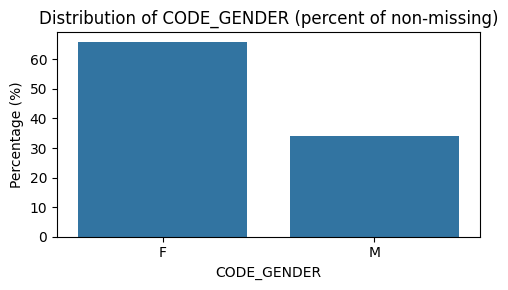

In [12]:
plot_feature_distribution(application_train, "CODE_GENDER")

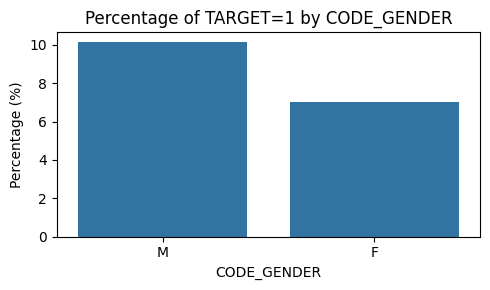

In [13]:
plot_feature_distribution(application_train, "CODE_GENDER", target_name="TARGET")

**Statistical test**

To test the hypothesis that being male influences the risk of default, a two-proportion Z-test was performed. This statistical test compares the default rates between two groups: males (`CODE_GENDER = 'M'`) and non-males (`CODE_GENDER ≠ 'M'`).

The difference in default proportions between these groups was calculated, along with a 95% confidence interval to quantify the uncertainty around this difference. The Z-test evaluates whether the observed difference is statistically significant or could have arisen by chance under the null hypothesis of no difference.

In [14]:
ct = pd.crosstab(application_train["CODE_GENDER"], application_train["TARGET"])
ct

TARGET,0,1
CODE_GENDER,,
F,188278,14170
M,94404,10655


Each group in the contingency table contains more than 10,000 cases, which satisfies the sample size requirements for the validity of the Z-test approximation.

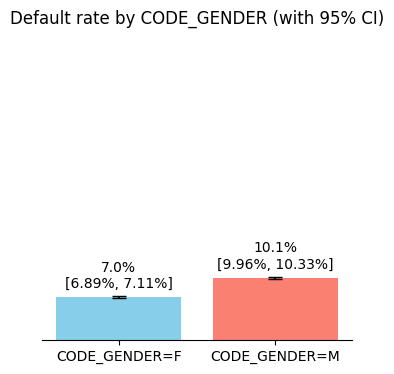

In [15]:
plot_proportion_with_ci(ct, label_prefix="CODE_GENDER")

In [16]:
success = application_train.groupby("CODE_GENDER")["TARGET"].sum()
n = application_train.groupby("CODE_GENDER")["TARGET"].count()

zstat, pval = proportions_ztest(count=success, nobs=n)
print(f"Z = {zstat:.2f}, p = {pval:.4f}")

Z = -30.34, p = 0.0000


The very large Z-test statistic and low p-value indicate a statistically significant difference in default rates between individuals with at least one defaulter in their social circle and those without. However, the average difference in proportions is only 3.1%, which is relatively small (see below).

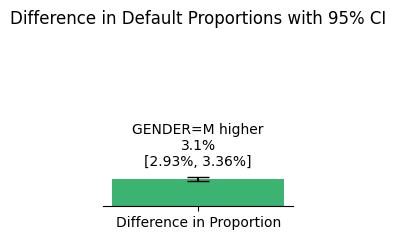

In [17]:
plot_difference_in_proportion(ct, feature_name="GENDER")

#### 2.2.3. <a id='toc2_2_3_'></a>[Hypothesis 3: Education level](#toc0_)

##### 2.2.3.1. <a id='toc2_2_3_1_'></a>[Hypotheses formulations](#toc0_)

3. Higher education level is associated with lower credit default risk
 
- Alternative Hypothesis ($H_A(3)$): The applicant's `EDUCATION_LEVEL` negatively affects the probability of defaulting — i.e., higher education levels are associated with a lower likelihood of default $(\beta_{\text{education}} < 0)$.
- Null Hypothesis ($H_0(3)$): There is no relationship between `EDUCATION_LEVEL` and the probability of defaulting $(\beta_{\text{education}} = 0)$.


The significance level set for this hypothesis to test is set a $\alpha$ level of 0.05.

##### 2.2.3.2. <a id='toc2_2_3_2_'></a>[EDUCATION_LEVEL](#toc0_)

We transform the categorical variable `NAME_EDUCATION_TYPE` into an ordinal scaled feature `EDUCATION_LEVEL`, while also merging **Academic Degree** (too small sample size) into **Higher Edcuation**:

In [18]:
from src.features import encode_education_level, merge_academic_degree_into_higher

application_train = merge_academic_degree_into_higher(application_train)
application_train = encode_education_level(application_train)

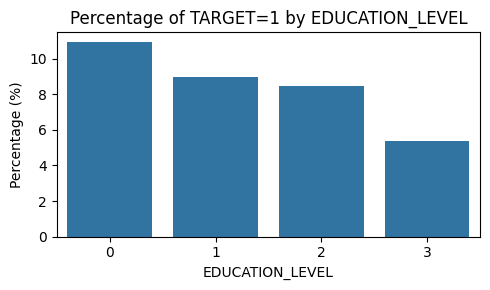

In [19]:
plot_feature_distribution(application_train, "EDUCATION_LEVEL", target_name="TARGET")

##### 2.2.3.3. <a id='toc2_2_3_3_'></a>[Test assumptions: Part 1](#toc0_)

There are multiple the key assumptions for logistic regression analysis, so we want to ensure they are all met.



The dependent variable is binary and observations are independent of each other (no repeated measures or related samples). There are no outliers that can disproportionately affect the model. Moreover, logistic regression requires a sufficiently large sample size to provide reliable estimates, especially for maximum likelihood estimation. This is given as following contingency table shows:

In [20]:
ct = pd.crosstab(application_train["EDUCATION_LEVEL"], application_train["TARGET"])
ct

TARGET,0,1
EDUCATION_LEVEL,,
0,3399,417
1,198865,19524
2,9404,872
3,71014,4012


Multicollinearity is of no concern, because we include only one feature into the model.

Logistic regression does not assume data normality, thus, that the predictors or the residuals are normally distributed.

**Linearity of Logits**

The relationship between continuous (ordinal) predictors and the log-odds of the outcome must be linear. We check this using Box-Tidwell test:



In [21]:
box_tidwell_results = box_tidwell_test(application_train, "TARGET", ["EDUCATION_LEVEL"])
print(box_tidwell_results)

         Predictor  Interaction_Coefficient   p-value
0  EDUCATION_LEVEL                -0.070318  0.031065


The p-value of 0.03 suggests that the effect of `EDUCATION_LEVEL` is not perfectly linear in the logit scale. We can see that already in the plot above as well as further below in the Partial Residual Plot (under Limitations): The drop in target proportion between `EDUCATION_LEVEL` **Lower secondary** and **Secondary / secondary special** is steeper than between the following education levels.

We report the limitation and run sensitivity checks therefore.

##### 2.2.3.4. <a id='toc2_2_3_4_'></a>[Hypothesis testing](#toc0_)

In [22]:
import statsmodels.api as sm

X = application_train[["EDUCATION_LEVEL"]]
X = sm.add_constant(X)
y = application_train["TARGET"]

model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.278818
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 TARGET   No. Observations:               307507
Model:                          Logit   Df Residuals:                   307505
Method:                           MLE   Df Model:                            1
Date:                Sat, 02 Aug 2025   Pseudo R-squ.:                0.006169
Time:                        17:11:04   Log-Likelihood:                -85738.
converged:                       True   LL-Null:                       -86271.
Covariance Type:            nonrobust   LLR p-value:                1.853e-233
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.0515      0.013   -153.996      0.000      -2.078      -2.025
EDUCATION_LEVE

The negative coefficient for `EDUCATION_LEVEL` (-0.2667) indicates that higher education levels are associated with a lower probability of default. The p-value is below the chosen significance threshold, confirming a statistically significant relationship. In logistic regression, coefficients represent changes in the log-odds of the outcome. Specifically, a one-unit increase in `EDUCATION_LEVEL` (i.e., moving from a lower to a higher education category) corresponds to a decrease of 0.2667 in the log-odds of default.

To make this effect more interpretable, we can convert the coefficient into odds ratios:

In [23]:
beta1 = model.params["EDUCATION_LEVEL"]

print(
    f"The odds of default decrease by about {(1-np.exp(beta1))*100:.1f}% for each higher education level."
)

The odds of default decrease by about 23.4% for each higher education level.


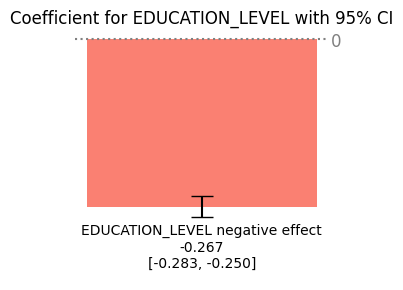

In [25]:
coef = model.params["EDUCATION_LEVEL"]
conf_int = model.conf_int().loc["EDUCATION_LEVEL"]

plot_coef_with_ci(coef, conf_int[0], conf_int[1], feature_name="EDUCATION_LEVEL")

##### 2.2.3.5. <a id='toc2_2_3_5_'></a>[Test assumptions: Part 2](#toc0_)

c:\Users\JO-840-G5\Desktop\py4e\jwerne-DS.v2.5.3.4.1\home_credit\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


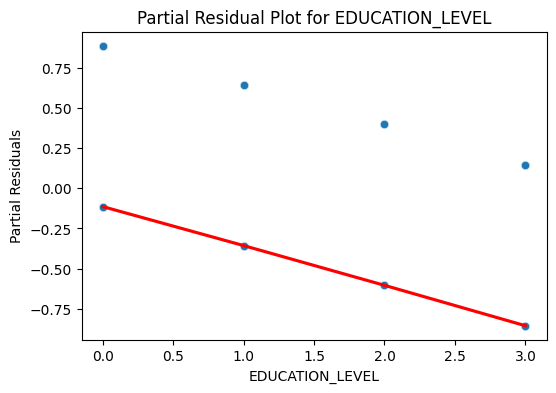

In [27]:
plot_partial_residuals(model, application_train, "EDUCATION_LEVEL")

A straight line in the above partial residual plot supports the linearity assumption. But a significant Box-Tidwell test indicated the relationship might deviate slightly from linearity, which could affect model validity if ignored. However, the coefficient was quite small (−0.07), and the partial residual plot looks nearly linear.

If using this Logistic Regression model for complex prediction task we would have to consider and test alternative functional forms. However, since our goal is just to test the hypothesis the slight non-linearity indicated by the Box-Tidwell test is less critical.

### 2.3. <a id='toc2_3_'></a>[Results](#toc0_)

1. ***Presence of Defaulters in Social Circle*** is positively associated with the risk of defaulting, with a p-value well below 0.001. Since this is a one-sided test for a positive effect, the adjusted p-value is half the original and remains significant. The lower boundary of the confidence interval for the difference in default proportions is greater than zero. Therefore, the null hypothesis can be **rejected**, confirming that applicants with defaulters in their social circle are significantly more likely to default.

2. ***Gender (Male)*** shows a significant positive effect on the risk of defaulting, with a p-value less than 0.001. As a one-sided test, the adjusted p-value remains below 0.0005. The confidence interval for the effect size does not include zero and indicates a higher risk for males. Thus, the null hypothesis can be **rejected**, concluding that being male is associated with increased default risk.

3. ***Education Level*** is negatively associated with the probability of defaulting, with a p-value under 0.001. This one-sided test for a negative effect yields an adjusted p-value below 0.0005. The upper boundary of the confidence interval for the education coefficient is below zero, supporting a protective effect of higher education. Consequently, the null hypothesis can be **rejected**, indicating that higher education levels correspond to a lower risk of default.

**Reg. 3.**, note: A Box-Tidwell test indicated a small but statistically significant deviation from the linearity assumption for EDUCATION_LEVEL. However, the partial residual plot showed an approximately linear relationship, and given the hypothesis-testing focus rather than prediction, this minor non-linearity is not expected to materially affect the interpretation of the negative effect.